In [2]:
from socceraction.data.wyscout import WyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
import pandas as pd

In [3]:
import os
#import wyscoutapi

def load_environment_vars():
    # Get the current working directory
    cwd = os.getcwd()

    # Append the .env file name
    env_path = os.path.join(cwd, '../.env')

    # Open the .env file
    with open(env_path) as f:
        # Read the lines
        lines = f.readlines()

    # Parse the key-value pairs
    for line in lines:
        # Ignore comments and empty lines
        if line.startswith('#') or not line.strip():
            continue
        # Split the line into key and value
        key, value = line.strip().split('=', 1)
        # Set the environment variable
        os.environ[key] = value

    return os.environ['WYSCOUT_API_USER'], os.environ['WYSCOUT_API_PASSWORD']

#def create_wyscout_client(username, password):
#    return wyscoutapi.WyscoutAPI(username=username, password=password)

In [4]:
# set authentication credentials as environment variables
username, password = load_environment_vars()

# or provide authentication credentials as a dictionary
api = WyscoutLoader(getter="remote", creds={"user":username, "passwd": password})

In [5]:
last_premier_games = api.games(364,188989)

/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarning: Resource not found: matches/5465087/events?fetch=teams,players,match,coaches,referees,formations,substitutions
  warnings.warn(f"Resource not found: {gamedetails_url}")
/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarning: Resource not found: matches/5465072/events?fetch=teams,players,match,coaches,referees,formations,substitutions
  warnings.warn(f"Resource not found: {gamedetails_url}")
/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarning: Resource not found: matches/5464939/events?fetch=teams,players,match,coaches,referees,formations,substitutions
  warnings.warn(f"Resource not found: {gamedetails_url}")
/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarnin

In [6]:
last_premier_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465110,364,188989,2024-01-02 19:30:00,20,1633,1651
1,5465105,364,188989,2024-01-01 20:00:00,20,1612,1613
2,5465104,364,188989,2023-12-31 14:00:00,20,1616,1609
3,5465109,364,188989,2023-12-31 14:00:00,20,1624,1659
4,5465108,364,188989,2023-12-30 17:30:00,20,1642,1611
...,...,...,...,...,...,...,...
191,5464915,364,188989,2023-08-12 14:00:00,1,1651,1660
192,5464916,364,188989,2023-08-12 14:00:00,1,1623,1616
193,5464917,364,188989,2023-08-12 14:00:00,1,1636,1628
194,5464913,364,188989,2023-08-12 12:00:00,1,1609,1642


In [7]:
last_games = last_premier_games

In [8]:
last_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465110,364,188989,2024-01-02 19:30:00,20,1633,1651
1,5465105,364,188989,2024-01-01 20:00:00,20,1612,1613
2,5465104,364,188989,2023-12-31 14:00:00,20,1616,1609
3,5465109,364,188989,2023-12-31 14:00:00,20,1624,1659
4,5465108,364,188989,2023-12-30 17:30:00,20,1642,1611
...,...,...,...,...,...,...,...
191,5464915,364,188989,2023-08-12 14:00:00,1,1651,1660
192,5464916,364,188989,2023-08-12 14:00:00,1,1623,1616
193,5464917,364,188989,2023-08-12 14:00:00,1,1636,1628
194,5464913,364,188989,2023-08-12 12:00:00,1,1609,1642


If we evaluate new games we need to update our features data

In [39]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

functions_labels = [
    labels.scores,
    labels.concedes
]

for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    last_game_event = api.events(game_id)
    spadl_df = convert_to_actions(last_game_event, home_team_id)
    team_name = api.teams(game_id=game_id)
    team_name.to_hdf('teams.h5', key=f'game_{game_id}')

    player_name = api.players(game_id=game_id)
    player_name.to_hdf('players.h5', key=f'game_{game_id}')

    df_actions = (
    spadl
    .add_names(spadl_df)  # add actiontype and result names
    .merge(team_name)  # add team names
    .merge(player_name)  # add player names
    )
    df_actions.to_hdf('actions.h5', key=f'game_{game_id}')

    #df_actions_atomic = atomicspadl.convert_to_atomic(df_actions)
    df_actions_atomic = (
        atomicspadl
        .add_names(df_actions)  # add actiontype and result names
        .merge(team_name)  # add team names
        .merge(player_name)  # add player names
        )

    df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
    
    gamestates = features.gamestates(df_actions,3)
    gamestates = features.play_left_to_right(gamestates, home_team_id)

    df_features = pd.concat([fn(gamestates) for fn in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    # 3. compute labels
    df_labels = pd.concat([fn(df_actions) for fn in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

/tmp/ipykernel_570617/3180989931.py:36: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['original_event_id', 'type_name', 'result_name', 'bodypart_name',
       'team_name_short', 'team_name', 'nickname', 'firstname', 'lastname',
       'player_name'],
      dtype='object')]

  df_actions.to_hdf('actions.h5', key=f'game_{game_id}')
/tmp/ipykernel_570617/3180989931.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['original_event_id', 'result_name', 'team_name_short', 'team_name',
       'nickname', 'firstname', 'lastname', 'player_name', 'type_name',
       'bodypart_name'],
      dtype='object')]

  df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
/home/pastor/anaconda3/envs/soccer

# Load label and features

In [16]:
last_games = last_premier_games.head(50)

In [17]:
dfs_features = []
dfs_labels = []
for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)

    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
    
df_labels = pd.concat(dfs_labels).reset_index(drop=True)
df_features = pd.concat(dfs_features).reset_index(drop=True)

In [18]:
df_labels.tail()

,scores,concedes,game_id
66358,True,False,5465054
66359,True,False,5465054
66360,True,False,5465054
66361,False,False,5465054
66362,False,False,5465054


In [19]:
df_features.tail(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2,game_id
66353,True,False,False,False,False,False,False,False,False,False,...,0.261047,79.676757,0.321274,80.034333,0.076542,True,True,195.0,895.0,5465054
66354,True,False,False,False,False,False,False,False,False,False,...,0.562912,86.945693,0.261047,79.676757,0.321274,True,True,6.0,201.0,5465054
66355,False,False,False,False,False,False,False,False,True,False,...,0.226320,48.421153,0.562912,86.945693,0.261047,True,True,-530.0,-524.0,5465054
66356,True,False,False,False,False,False,False,False,False,False,...,0.272688,48.486461,0.226320,48.421153,0.562912,True,True,81.0,-449.0,5465054
66357,True,False,False,False,False,False,False,False,False,False,...,0.463581,47.972559,0.272688,48.486461,0.226320,True,True,13.0,94.0,5465054
66358,False,False,False,False,False,False,False,False,False,False,...,0.755536,66.912098,0.463581,47.972559,0.272688,True,True,439.0,452.0,5465054
66359,False,False,False,False,False,False,False,False,False,False,...,0.837575,15.867479,0.755536,66.912098,0.463581,True,True,2.0,441.0,5465054
66360,False,False,False,False,False,False,False,False,False,False,...,1.570796,10.982172,0.837575,15.867479,0.755536,True,True,2.0,4.0,5465054
66361,True,False,False,False,False,False,False,False,False,False,...,0.304248,3.400000,1.570796,10.982172,0.837575,True,True,259.0,261.0,5465054
66362,True,False,False,False,False,False,False,False,False,False,...,0.606605,72.635994,0.304248,3.400000,1.570796,True,True,37.0,296.0,5465054


# Split the dataset

- Stratification: we want to keep the same distribution of classes in the train and test set, since we have two different class labels we provided a concatenation of the two labels to the stratify parameter.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_labels['concedes'].value_counts()

False    66363
Name: concedes, dtype: int64

In [22]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.1,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [23]:
df_y_train['scores'].mean()

0.021766065030305058

In [24]:
df_y_test['scores'].mean()

0.021696549645924365

In [25]:
df_y_train['concedes'].mean()

0.0

In [26]:
df_y_test['concedes'].mean()

0.0

**Note**: In a real-world scenario where more data is available, you should consider respecting the chronological order of the games to construct the training set, validation set and test set. For instance, use the data for the 2016/2017 and 2017/2018 seasons to train the models, use the data for the 2018/2019 season to tune the models, and use the data for the 2019/2020 season to obtain the results.

## Construct baseline classfiers

In [27]:
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]

In [28]:
labels = ['scores',
          #'concedes'
          ]

## Train classifier

In [30]:
!pip install tqdm -q

In [36]:
from tqdm import tqdm
# import XGBclassifier

from xgboost import XGBClassifier

In [37]:
%%time

models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators = 10,
        max_depth = 3

    )

    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
        )
    models[label] = model

100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

CPU times: user 559 ms, sys: 30.7 ms, total: 590 ms
Wall time: 291 ms


In [38]:
models

{'scores': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=10, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}

## 4.2 Estimate the probabilities

In [40]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

100%|██████████| 1/1 [00:00<00:00, 63.17it/s]


In [42]:
df_predictions.head(10)

,scores
48182,0.015490
57318,0.016545
49850,0.013730
23841,0.013730
36124,0.016545
46294,0.029719
35043,0.035335
40673,0.042633
41131,0.015490
43812,0.013730


## 4.3 Evaluate the probabilities

### 4.3.1 Compute base rate probabilities

The following cell computes the base rate or prior probability of each class label in the training set. We use the base rate as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

In [43]:
import numpy as np

The `np.full()` function in NumPy is used to create a new array of given shape and type, filled with a fill value. Here's the syntax of the `np.full()` function:

```python
numpy.full(shape, fill_value, dtype=None, order='C')
```

Parameters:

- `shape`: Shape of the new array, e.g., `(2, 3)` or `2`.
- `fill_value`: Fill value.
- `dtype` (optional): The desired data type for the array. If not given, then the type will be determined as the minimum type required to hold the objects in the sequence.
- `order` (optional): Whether to store multidimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

Here's an example of how to use the `np.full()` function:

```python
import numpy as np

# Create a new 2x3 array filled with 7
arr = np.full((2, 3), 7)

print(arr)
```

Output:

```
[[7 7 7]
 [7 7 7]]
```

In this example, `np.full((2, 3), 7)` creates a new 2x3 array filled with 7.

In [44]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
    })

In [45]:
df_base_rates.head()

,scores
0,0.021766
1,0.021766
2,0.021766
3,0.021766
4,0.021766


## 4.3.2 Compute Brier score loss for goal scored model

In [46]:
from sklearn.metrics import brier_score_loss, roc_auc_score

The following computes the Brier loss score for the base rate predictions

In [47]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_base_rates['scores']
)

0.021225814211774968

The following computes the Brier loss score for the prediction by the learned model.

In [48]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_predictions['scores']
)

0.020100580801071005

We can also make the same calculation for conceded goals

In [ ]:
#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_base_rates['conceded']
#)

#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_predictions['conceded']
#)

## 4.3.4 Plot the calibration curve and probability histogram

In [53]:
!pip install scikit-plot -q

In [54]:
from scikitplot.metrics import plot_calibration_curve

In [49]:
import matplotlib.pyplot as plt

<Axes: ylabel='Frequency'>

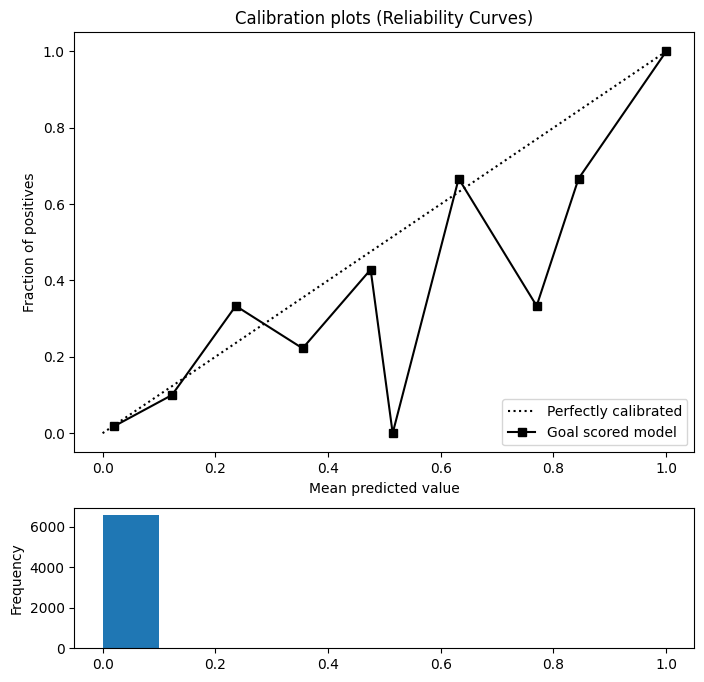

In [57]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={'height_ratios':[3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)

df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

# 5 Optimize classifiers

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>